# Сверточный слой в Tensorflow

В этом уроке мы познакомимся с определением сверточного слоя в Tensorflow

In [1]:
import tensorflow as tf
import numpy as np

2024-05-02 20:43:28.518299: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-02 20:43:29.361150: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Как и все слои в tf.keras, сверточный слой находится в tf.keras.layers и называется Conv2D:

In [2]:
from tensorflow.keras.layers import Conv2D

Рассмотрим его параметры подробнее

In [3]:
 Conv2D?

Init signature:
Conv2D(
    filters,
    kernel_size,
    strides=(1, 1),
    padding='valid',
    data_format=None,
    dilation_rate=(1, 1),
    groups=1,
    activation=None,
    use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs,
)
Docstring:     
2D convolution layer.

This layer creates a convolution kernel that is convolved with the layer
input over a single spatial (or temporal) dimension to produce a tensor of
outputs. If `use_bias` is True, a bias vector is created and added to the
outputs. Finally, if `activation` is not `None`, it is applied to the
outputs as well.

Args:
    filters: int, the dimension of the output space (the number of filters
        in the convolution).
    kernel_size: int or tuple/list of 2 integer, specifying the size of the
        convolution window.
    strides:

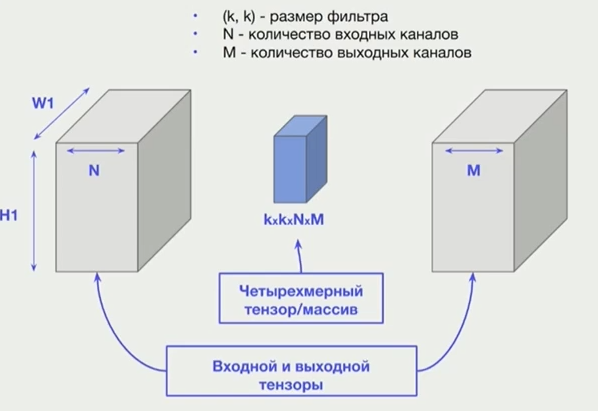


```
Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', ...)
```


*   filters -- количество выходных каналов. M -- на иллюстрации выше
*   kernel_size -- размер фильтра (ядра). (k,k) -- на иллюстрации.
*   padding -- значение "valid" по умолчанию, означает, что свертка "откусит" часть входного тензора. Например, при размере фильтра 3 -- размер уменьшится на пиксель с каждой стороны, при фильтре 5 -- на два и т.д. Второе значение -- "same", автоматически подберет паддинг из нулей для того, чтобы размер не изменился
*   activation -- знакомая нам активация (например, "relu"). Применяется сразу после свертки и добавления вектора смещения поэлементно
*   use_bias -- использовать ли смещение после свертки. Добавляет число к каждому из выходных каналов
*   kernel_initializer, bias_initializer -- инициализаторы ядра и смещения, аналогично Dense слою

Обратите внимаение, мы не указали количество входных каналов. Как и в случае полносвязного слоя, Keras вычислит это автоматически.


Для знакомства со сверточным слоем -- реализуем операцию свертки, которую мы считали на лекции.
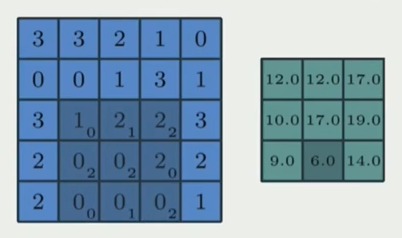



In [4]:
from tensorflow.python.keras.layers.convolutional import Conv2D
signal = np.array([[3,3,2,1,0],
                   [0,0,1,3,1],
                   [3,1,2,2,3],
                   [2,0,0,2,2],
                   [2,0,0,0,1]])

# для начала создадим слой. количество выходных каналов -- 1, размер (3,3)
conv_layer = Conv2D(kernel_size=(3, 3), filters=1, use_bias=False)


# применим слой (пусть пока со случайным фильтром) ко входу. и ... получим ошибку)
_ = conv_layer(signal)

2024-05-02 20:47:01.447223: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-05-02 20:47:01.447258: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: hik0
2024-05-02 20:47:01.447267: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: hik0
2024-05-02 20:47:01.447376: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 545.29.6
2024-05-02 20:47:01.447406: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 545.29.6
2024-05-02 20:47:01.447414: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 545.29.6


ValueError: Input 0 of layer conv2d is incompatible with the layer: : expected min_ndim=4, found ndim=2. Full shape received: (5, 5)

In [5]:
signal.shape

(5, 5)

Мы получили ошибку  о несовпадении размерностей *'expected ndim=4, found ndim=2. Full shape received: [5, 5]'*.

Т.е. слой ожидает четырехмерный тензор, а мы передали двумерный. Одна из потерянных размерностей -- количество каналов. Хоть мы и применяем фильтр к двумерному массиву с одним каналом -- мы должны описать эту размерность. Вторая -- batch dimension, которая отвечает за количество объектов. В нашем примере -- это тоже 1.

In [6]:
 # используем метод reshape
signal = signal.reshape((1, 5, 5, 1)).astype(np.float32)
print(signal.shape)

(1, 5, 5, 1)


In [7]:
output = conv_layer(signal) # теперь код работает без ошибки
output.numpy().shape

(1, 3, 3, 1)

In [8]:
# размер фильтра (k,k,количество_входных_каналов, воличество_каналов_на_выходе)
conv_layer.get_weights()[0].shape

(3, 3, 1, 1)

А теперь инициализируем наш слой с помощью ядра, которое опишем ниже. Мы воспользуемся методом set_weights(). На практике мы почти никогда не инициализируем параметры самостоятельно, но в данном уроке мы будем часто пользоваться этим в образовательных целях.

In [9]:
kernel = np.array([[0, 1, 2],
                   [2, 2, 0],
                   [0, 1, 2]])

kernel = kernel.reshape((3, 3, 1, 1)).astype(np.float32)

In [10]:
conv_layer.set_weights([kernel])

conv_layer(signal)[0, :, :, 0].numpy()
# Можно убедиться, что мы получили правильный ответ

array([[12., 12., 17.],
       [10., 17., 19.],
       [ 9.,  6., 14.]], dtype=float32)

In [11]:
conv_layer(signal).numpy()

array([[[[12.],
         [12.],
         [17.]],

        [[10.],
         [17.],
         [19.]],

        [[ 9.],
         [ 6.],
         [14.]]]], dtype=float32)

А теперь попробуем применить свертку к изображению в градациях серого.

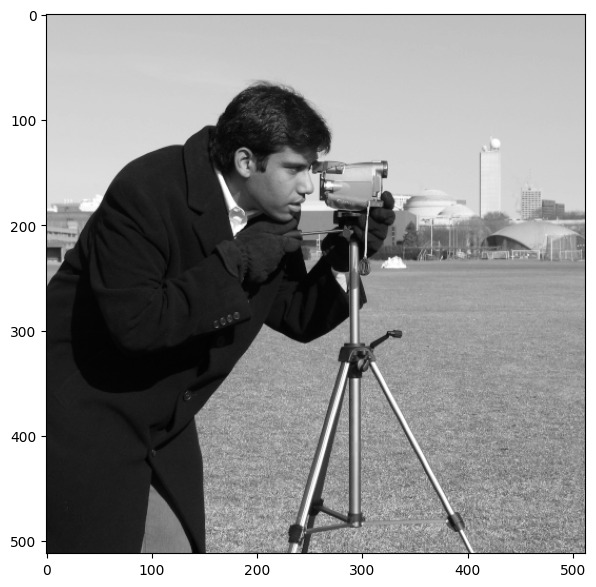

In [13]:
from skimage import data
import matplotlib.pyplot as plt

image = data.camera()
plt.figure(figsize=(7, 7))
plt.imshow(image, cmap="gray")

In [14]:
print(image.shape)
image = image[None, ... , None]  # так тоже можно добавлять дополнительные размерности
print(image.shape)
image = image.astype(np.float32) / 255. # !!! обязательно приводим к флоату.
                                        # делить на 255 не обязательно, но от float картинки matplotlib ожидает значений  от 0 до 1.

(512, 512)
(1, 512, 512, 1)


Ниже мы создадим фильтр, который будем размывать изображение, аналогично рассмотреному на лекции. Для разнообразия используем фильтр бОльшего размера.

In [15]:
conv_layer = Conv2D(kernel_size=(7, 7), filters=1, use_bias=False) # мы используем фильтр размера (7, 7).
                                                                   # и т.к. мы хотим получить на выходе также одноканальное изображение,
                                                                   # укажем количество каналов на выходе = 1
_ = conv_layer(image) # чтобы получить доступ к весам слоя нужно один раз им воспользоваться.

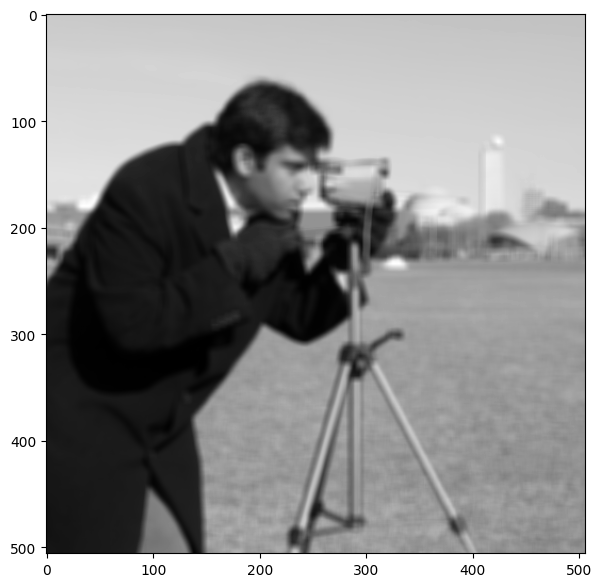

In [16]:
kernel = np.ones((7, 7, 1, 1)) * 1./49 # усредняем значение всех пикселей, которые попали в окошко (7,7)
conv_layer.set_weights([kernel])

blur_image = conv_layer(image).numpy()
plt.figure(figsize=(7, 7))
plt.imshow(blur_image[0, :, :, 0], cmap="gray")

In [17]:
# обратите внимание на размеры:
image.shape, blur_image.shape
# свертка размера 7 без паддинга съест по три пикселя с каждой стороны -- 512-3*2 = 506

((1, 512, 512, 1), (1, 506, 506, 1))

А теперь поэксперентируем с цветными изображениями

(1, 400, 600, 3)

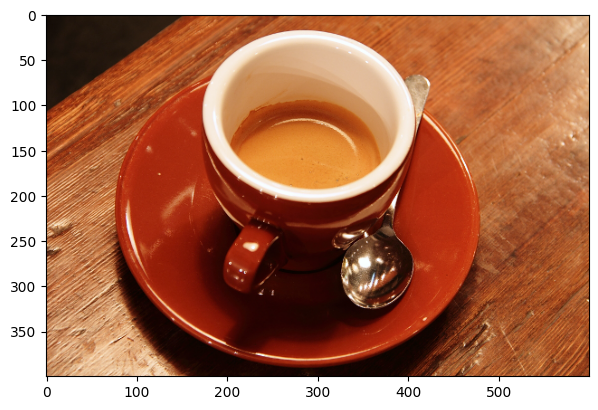

In [18]:
image = data.coffee()
plt.figure(figsize=(7, 7))
plt.imshow(image)
image = image[None, :, :].astype(np.float32) / 255.
image.shape

In [19]:
conv_layer = Conv2D(kernel_size=(5, 5), filters=3, use_bias=False)
_ = conv_layer(image)

conv_layer.get_weights()[0].shape

(5, 5, 3, 3)

Попробуем теперь определить фильтр размытия. Для цветного изображения это немного сложнее.

Input shape (1, 400, 600, 3). Output shape (1, 396, 596, 3)


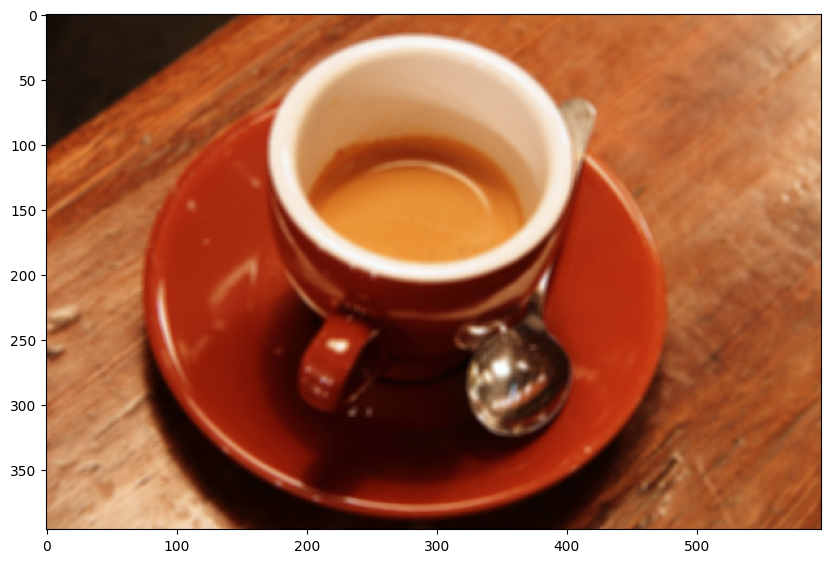

In [20]:
kernel = np.zeros((5,5,3,3))

kernel[:, :, 0, 0] = 1/25. # размытие нулевого канала 0, 0 -- означает, что нулевой канал выхода зависит от нулевого канала входа
                           # [:, :, 1, 0] и [:, :, 2, 0] -- остались равными нулю.
kernel[:, :, 1, 1] = 1/25.
kernel[:, :, 2, 2] = 1/25.
conv_layer.set_weights([kernel])

plt.figure(figsize=(10, 10))
plt.imshow(conv_layer(image).numpy()[0])
print(f"Input shape {image.shape}. Output shape {conv_layer(image).numpy().shape}")

Input shape (1, 400, 600, 3). Output shape (1, 396, 596, 3)


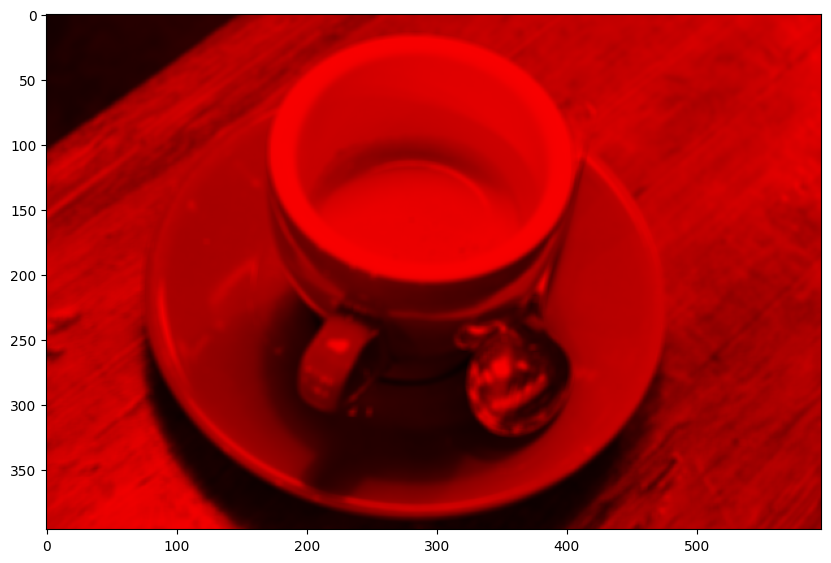

In [25]:
kernel = np.zeros((5,5,3,3))

kernel[:, :, 0, 0] = 1/25. # если оставить только эту строчку -- размоем только нулевой канал (красный), а остальные занулим

conv_layer.set_weights([kernel])

plt.figure(figsize=(10, 10))
plt.imshow(conv_layer(image).numpy()[0])
print(f"Input shape {image.shape}. Output shape {conv_layer(image).numpy().shape}")

Но как вы знаете, свертки можно применять не только к изображениям. Ниже несколько примеров:

In [26]:
conv_layer = Conv2D(kernel_size=(5,5), filters=30)
sample_input = np.random.rand(1, 200, 300, 20)
conv_layer(sample_input).numpy().shape

(1, 196, 296, 30)

In [27]:
conv_layer = Conv2D(kernel_size=(5,5), filters=30, padding="same")
sample_input = np.random.rand(1, 200, 300, 20)
conv_layer(sample_input).numpy().shape

(1, 200, 300, 30)

In [28]:
# Можно добавить активациюю Обратите внимание -- на выходе только неотрицательные значения -- это работа ReLU
conv_layer = Conv2D(kernel_size=(3,3), filters=1, padding="same", activation="relu")
sample_input = np.random.rand(1, 5, 5, 1)
conv_layer(sample_input).numpy()[0, :, :, 0]

array([[0.        , 0.        , 0.4135822 , 0.13585788, 0.31846905],
       [0.        , 0.        , 0.        , 0.30806595, 0.32797658],
       [0.        , 0.1355572 , 0.01691067, 0.33345455, 0.47966242],
       [0.        , 0.38283128, 0.        , 0.2935103 , 0.22787586],
       [0.        , 0.12934744, 0.        , 0.        , 0.3186507 ]],
      dtype=float32)

# Итог
В этом уроке мы познакомились с устройством сверточного слоя в Tensorflow.

А теперь переходите к [практике](https://colab.research.google.com/drive/1oN8fusLAxNHaqicbfsAiIfRBiFRmWWfl), чтобы закрепить знания.